In [ ]:
# trying to build a custom feature selection scoring function

# build with SelectKBest in mind: 
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest

# SelectKBest(score_func=<function f_classif>, *, k=10)

# https://github.com/scikit-learn/scikit-learn/blob/8c9c1f27b7e21201cfffb118934999025fd50cca/sklearn/feature_selection/_univariate_selection.py#L120

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import sklearn.feature_selection
from sklearn.feature_selection import SelectKBest
from sklearn.utils import check_X_y, safe_mask, as_float_array
import os.path

# proj_root = '/content/drive/MyDrive/STAT685/project'
proj_root = 'G:/My Drive/STAT685/project'
slope_data_file = 'DATA/prof_standardmethod_matload_872.csv'

col_names = ["slope_"+str(i+1) for i in range(29)]
col_names.append("state")

ov_slope_std = pd.read_csv(os.path.join(proj_root, slope_data_file), 
                           header = None,
                           names = col_names)

print(ov_slope_std.shape)
print(ov_slope_std.isna().sum().sum())
print(ov_slope_std.head())
print(ov_slope_std.describe())

(253, 30)
0
    slope_1   slope_2   slope_3   slope_4   slope_5   slope_6   slope_7  \
0 -1.390012 -1.985382 -2.028890 -2.073865 -2.123799 -1.482906 -1.522051   
1 -1.522349 -1.807224 -1.883326 -1.955082 -2.019010 -1.225661 -1.643970   
2 -1.508330 -1.926218 -1.995107 -2.027103 -2.089810 -1.452323 -1.492603   
3 -1.595252 -1.900430 -1.945393 -1.959034 -2.077736 -1.505248 -1.506090   
4 -1.452474 -1.929245 -1.979982 -2.035807 -2.206432 -1.435100 -1.550661   

    slope_8   slope_9  slope_10  ...  slope_21  slope_22  slope_23  slope_24  \
0 -1.795314 -1.743730 -1.772361  ... -2.901123 -2.027348 -1.720804 -2.191500   
1 -1.836803 -1.727575 -1.807181  ... -3.088755 -1.891386 -1.901357 -2.674343   
2 -1.842304 -1.700727 -1.719410  ... -3.202787 -2.548005 -1.619726 -2.874125   
3 -1.763864 -1.610091 -1.646536  ... -3.555931 -2.652216 -1.513916 -2.634507   
4 -1.778446 -1.551708 -1.501649  ... -3.027263 -2.130455 -1.552711 -2.577427   

   slope_25  slope_26  slope_27  slope_28  slope_29  sta

In [2]:
def fisher_table(*args):
  args = [as_float_array(a) for a in args]
  fisher_score = ((np.mean(args[0], axis = 0) - np.mean(args[1], axis = 0))**2 /
    (np.var(args[0], axis = 0) + np.var(args[1], axis = 0)))
  return fisher_score

def fisher_crit(X, y):
  # TODO somehow check that y only has 2 unique values?
  # TODO check that X has at least K features? or maybe SelectKBest already does that
  X, y = check_X_y(X, y)
  args = [X[safe_mask(X, y == k)] for k in np.unique(y)]
  return fisher_table(*args)

X = ov_slope_std.drop("state", axis=1).to_numpy()
y = ov_slope_std["state"].to_numpy()
print(X.shape, y.shape)

fisher_crit(X, y)

(253, 29) (253,)


array([4.06770164e-01, 3.41186824e-04, 2.01674268e-03, 2.03349485e-01,
       4.91322652e-02, 4.50462155e-02, 3.54727101e-03, 6.93736710e-02,
       2.50006198e-01, 1.20137992e-01, 1.43022500e-02, 2.68638592e-01,
       1.17965174e-04, 3.25461923e-03, 4.74878866e-02, 6.40444298e-02,
       9.04794945e-01, 1.07133231e+00, 2.72543775e-01, 2.68760832e-05,
       1.09298096e-02, 4.50118812e-01, 4.94550804e-02, 7.36516529e-02,
       2.73315505e-03, 5.85003218e-01, 3.07691325e-01, 4.92441651e-02,
       1.17896442e-01])

In [3]:
# X_new = SelectKBest(chi2, k=20).fit_transform(X, y)

# Well, this does it, but there is not a convenient way to get the feature names

X_new = SelectKBest(fisher_crit, k=5).fit_transform(X, y)

skb = SelectKBest(fisher_crit, k=5).fit(X, y)
skb.get_feature_names_out(col_names[:-1])

# X_new.shape
# X_new.head()
# X_new[0:5, :]

array(['slope_1', 'slope_17', 'slope_18', 'slope_22', 'slope_26'],
      dtype=object)

In [4]:
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores
core = 6

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, \
  RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix#, accuracy_score, roc_auc
import matplotlib.pyplot as plt
import seaborn as sns

X_train, X_test, y_train, y_test = \
  train_test_split(X, y, test_size=0.33, random_state = 0, 
                   shuffle = True, stratify = y)

print(X_train.shape)

kbest = 5
rng = np.random.RandomState(0)
scoring = ['roc_auc', 'accuracy']

# a function to return a dataframe with useful columns from CV results
def cv_summary(cv_obj, score_names = ['score']):
  cv_res = pd.DataFrame(cv_obj.cv_results_)
  cols = [col for col in cv_res.columns if 'param_' in col]
  stats = ['mean', 'std', 'rank']
  test_score_names = [stat+'_test_'+score for score in score_names for stat in stats]
  test_scores = [col for col in cv_res.columns if col in test_score_names]
  cols.extend(test_scores)
  return(cv_res[cols].sort_values(test_score_names[0], ascending = False))

(169, 29)


In [6]:
# penalized Logistic regression, with no undersampling

logreg = LogisticRegression(penalty = 'elasticnet', solver = 'saga', 
                            max_iter = 200, random_state = rng)
lr_params = {'logreg__C': [0.01, 0.1, 1, 5, 10, 25],
             'logreg__class_weight': ['balanced', None],
             'logreg__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
             'skb__k': [5]}

fisher_tune = Pipeline([('scaler', StandardScaler()),
                        ('skb', SelectKBest(fisher_crit, k=kbest)),
                        ('logreg', logreg)])

cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 1)

lr_cv = GridSearchCV(fisher_tune, param_grid=lr_params, scoring = scoring, 
                     n_jobs=-1, refit='roc_auc', cv=cv, verbose = 4)


Fitting 15 folds for each of 60 candidates, totalling 900 fits
{'logreg__C': 10, 'logreg__class_weight': None, 'logreg__l1_ratio': 1, 'skb__k': 5}
0.9229760979760981
   param_logreg__C param_logreg__class_weight param_logreg__l1_ratio  \
59              25                       None                      1   
49              10                       None                      1   
58              25                       None                   0.75   
39               5                       None                      1   
57              25                       None                    0.5   

   param_skb__k  mean_test_roc_auc  std_test_roc_auc  rank_test_roc_auc  \
59            5           0.922976          0.042429                  1   
49            5           0.922976          0.042609                  1   
58            5           0.922976          0.042429                  1   
39            5           0.922964          0.042398                  4   
57            5           

<Axes: xlabel='param_skb__k', ylabel='mean_test_accuracy'>

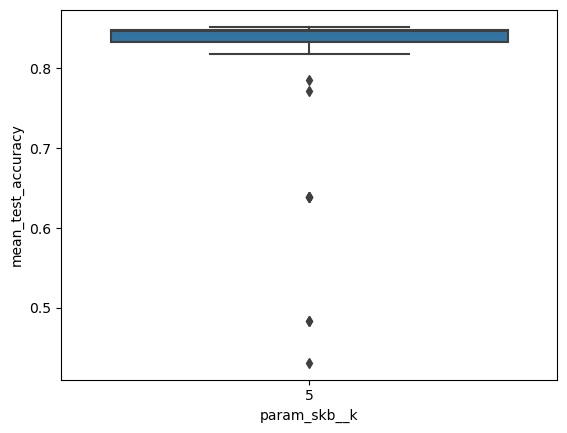

In [7]:
# fit and show results

lr_cv.fit(X_train, y_train)

print(lr_cv.best_params_)
print(lr_cv.best_score_)

lr_res = cv_summary(lr_cv, scoring)

# print(lr_cv.best_estimator_.named_steps.logreg.coef_)
# (lr_res.iloc[0][['std_test_roc_auc', 'std_test_accuracy']]) / 15**0.5
print(lr_res.head())

sns.boxplot(data = lr_res, x = 'param_skb__k', y = 'mean_test_accuracy')

In [ ]:
# penalized Logistic regression, with undersampling

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

# this results in an error when I run it - is it because imblearn does not implement these transformers in the usual way?
# do I need to use the special imblearn Pipeline?
# https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html#imblearn.pipeline.Pipeline

# TODO should random_state maybe be set to a random instance, instead?
fisher_und_tune = \
  make_pipeline(RandomUnderSampler(random_state = 7), StandardScaler(), \
                SelectKBest(fisher_crit, k=kbest), logreg)
# TODO if I am testing the same parameters, I should really use the same dictionary
# but I made a separate one because I am using the different Pipeline and make_pipeline constructors
# I should figure out if I can use sklearn.pipeline.Pipeline and imblearn.pipeline.Pipeline in the same script
lr_und_params = {'logisticregression__C': [0.1, 1, 5, 10, 25],
                 'logisticregression__class_weight': [None],
                 'logisticregression__l1_ratio': [0, 0.25, 0.5, 0.75, 1]}
lr_und_cv = GridSearchCV(fisher_und_tune, param_grid=lr_und_params, 
                         scoring = scoring, n_jobs=-1, refit = 'roc_auc', 
                         cv=cv, verbose = 4)

lr_und_cv.fit(X_train, y_train)

print(lr_und_cv.best_params_)
print(lr_und_cv.best_score_)

print(cv_summary(lr_und_cv, scoring).head())

Fitting 15 folds for each of 25 candidates, totalling 375 fits
{'logisticregression__C': 25, 'logisticregression__class_weight': None, 'logisticregression__l1_ratio': 1}
0.9184324934324934
   param_logisticregression__C param_logisticregression__class_weight  \
24                          25                                   None   
23                          25                                   None   
22                          25                                   None   
21                          25                                   None   
19                          10                                   None   

   param_logisticregression__l1_ratio  mean_test_roc_auc  std_test_roc_auc  \
24                                  1           0.918432          0.050031   
23                               0.75           0.918180          0.050106   
22                                0.5           0.917927          0.050578   
21                               0.25           0.917927    

In [ ]:
# I've tried doing LightGBM using a RandomState instance, but it fails because it is an old version
# the issue was fixed in version 3.0.0

%pip list

In [ ]:
# LightGBM, default parameters

from lightgbm.sklearn import LGBMClassifier

rng_lgbm = np.random.RandomState(1)

lgbm_pipe = Pipeline([('scaler', StandardScaler()),
                        ('skb', SelectKBest(fisher_crit, k=kbest)),
                        ('lgbm', LGBMClassifier(random_state = 7))])

# result with no tuning
lgbm_cv_score = cross_val_score(lgbm_pipe, X_train, y_train, cv=cv, n_jobs = cores)
print(np.mean(lgbm_cv_score), np.std(lgbm_cv_score))

0.8541889483065952 0.06550876915996347


In [ ]:
# LightGBM, with hyperparameter tuning

# TODO can I use this article to figure out how to do Early Stopping?
# https://towardsdatascience.com/how-to-beat-the-heck-out-of-xgboost-with-lightgbm-comprehensive-tutorial-5eba52195997
# maybe I need to use this different train, test, eval split function?
# or perhaps do a regular train, test split
# but then do another split on the train split, to give eval set?

lgbm_params = {
    # 'lgbm__max_depth': [4, 10],
    'lgbm__num_leaves': [4, 24, 72],
    'lgbm__learning_rate': [0.001, 0.005, 0.01],
    'lgbm__n_estimators': [250, 500, 2000],
    'lgbm__min_child_samples': [3, 10, 20],
    'lgbm__colsample_bytree': [0.4, 0.6]
}

lgbm_cv = GridSearchCV(lgbm_pipe, param_grid = lgbm_params, scoring=scoring, n_jobs = cores, 
                       refit = 'roc_auc', cv=cv, verbose = 4)
# took about 3-4 minutes to run with 216 param combinations and 2 cores
# took about 5 minutes to run with all features, 243 param combinations and 2 cores
lgbm_cv.fit(X_train, y_train)

In [ ]:
# print results of LightGBM tuning

print(lgbm_cv.best_score_)
print(lgbm_cv.best_params_)
print(cv_summary(lgbm_cv, scoring).head(10))

0.8878193701723113
{'lgbm__colsample_bytree': 0.6, 'lgbm__learning_rate': 0.001, 'lgbm__min_child_samples': 20, 'lgbm__n_estimators': 2000, 'lgbm__num_leaves': 4}
    param_lgbm__colsample_bytree param_lgbm__learning_rate  \
105                          0.6                     0.001   
122                          0.6                     0.005   
121                          0.6                     0.005   
96                           0.6                     0.001   
153                          0.6                      0.01   
107                          0.6                     0.001   
130                          0.6                     0.005   
106                          0.6                     0.001   
131                          0.6                     0.005   
144                          0.6                      0.01   

    param_lgbm__min_child_samples param_lgbm__n_estimators  \
105                            20                     2000   
122                           

In [ ]:
# LightGBM, using Halving tuning

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html#sklearn-model-selection-halvinggridsearchcv

from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV

lgbm_halve_params = lgbm_params
lgbm_halve_params['skb__k'] = [5, 'all']

lgbm_halve_cv = \
  HalvingGridSearchCV(lgbm_pipe, param_grid = lgbm_params, factor = 2, 
                      n_jobs = cores, cv=cv, scoring = 'roc_auc', verbose = 4)

# took about 15 min to run, finished after 2 iterations
lgbm_halve_cv.fit(X_train, y_train)

n_iterations: 2
n_required_iterations: 9
n_possible_iterations: 2
min_resources_: 60
max_resources_: 169
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 324
n_resources: 60
Fitting 15 folds for each of 324 candidates, totalling 4860 fits
----------
iter: 1
n_candidates: 162
n_resources: 120
Fitting 15 folds for each of 162 candidates, totalling 2430 fits


HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
                    estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('skb',
                                               SelectKBest(k=5,
                                                           score_func=<function fisher_crit at 0x7f484581d280>)),
                                              ('lgbm',
                                               LGBMClassifier(random_state=7))]),
                    factor=2, n_jobs=2,
                    param_grid={'lgbm__colsample_bytree': [0.4, 0.6],
                                'lgbm__learning_rate': [0.001, 0.005, 0.01],
                                'lgbm__min_child_samples': [3, 10, 20],
                                'lgbm__n_estimators': [250, 500, 2000],
                                'lgbm__num_leaves': [4, 24, 72],
                                'skb__k': [5, 'all']},
               

0.9021739130434784
{'lgbm__colsample_bytree': 0.4, 'lgbm__learning_rate': 0.001, 'lgbm__min_child_samples': 10, 'lgbm__n_estimators': 2000, 'lgbm__num_leaves': 72, 'skb__k': 'all'}
    param_lgbm__colsample_bytree param_lgbm__learning_rate  \
327                          0.6                     0.005   
376                          0.6                     0.001   
374                          0.6                     0.001   
377                          0.6                     0.001   
343                          0.6                      0.01   

    param_lgbm__min_child_samples param_lgbm__n_estimators  \
327                            10                      500   
376                            10                     2000   
374                            10                     2000   
377                            10                     2000   
343                            10                      250   

    param_lgbm__num_leaves param_skb__k  mean_test_score  std_test_score 

<AxesSubplot:xlabel='param_skb__k', ylabel='mean_test_score'>

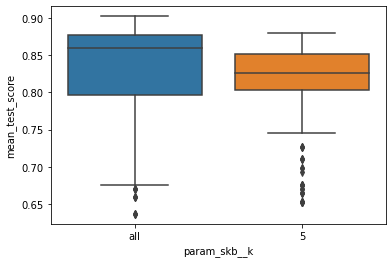

In [ ]:
# print results of LightGBM halving tuning

print(lgbm_halve_cv.best_score_)
print(lgbm_halve_cv.best_params_)

l_halve_res = cv_summary(lgbm_halve_cv, 'roc_auc')
print(l_halve_res[l_halve_res['param_skb__k'] == 5].head())

sns.boxplot(data = l_halve_res, x = 'param_skb__k', y = 'mean_test_roc_auc')

In [27]:
# other feature selection methods

from sklearn.feature_selection import RFE

rfe_params = {'logreg__C': [0.01, 0.1, 1, 5, 10, 25],
             'logreg__class_weight': ['balanced', None],
             'logreg__l1_ratio': [0, 0.25, 0.5, 0.75, 1]}

rfe_lr_pipe = Pipeline([('scale', StandardScaler()),
                    ('rfe', RFE(LogisticRegression(), n_features_to_select = 5)),
                   ('logreg', logreg)])

# lr_cv = GridSearchCV(fisher_tune, param_grid=lr_params, scoring = scoring, 
                    #  n_jobs=-1, refit='roc_auc', cv=cv, verbose = 4)

rfe_cv = GridSearchCV(rfe_lr_pipe, param_grid = rfe_params, scoring = scoring,
                      n_jobs = -1, refit = 'roc_auc', cv = cv, verbose = 4)

rfe_cv.fit(X_train, y_train)

rfe_cv_summ = cv_summary(rfe_cv, scoring)
print(rfe_cv_summ.sort_values(['rank_test_accuracy', 'rank_test_roc_auc']).head())
print(rfe_cv_summ.head())

print(rfe_cv.best_params_)
print(f'Best ROC AUC: {rfe_cv.best_score_}')
# are the paramater labels 0-indexed??
print(rfe_cv.best_estimator_.named_steps.rfe.get_feature_names_out())

(60, 9)